In [1]:
import networkx as nx
import pandas as pd
import re

from collections import Counter
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
%matplotlib inline
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
init_notebook_mode(connected=True)
import random
import colorlover as cl
from IPython.display import HTML

# Q1: Choose a Hashtag
#twitpocalypse

In [2]:
tp_df = pd.DataFrame.from_csv("backup-df-twitpocalypse.csv")

In [3]:
tp_df.head()

date           user  \
0  2009-06-11 19:13:16        yarthox   
1  2009-06-11 19:18:02       richpria   
2  2009-06-11 19:23:53  viviannesilva   
3  2009-06-11 19:29:18         jcodec   
4  2009-06-11 19:31:10     vinipontes   

                                               tweet  
0  Twitter fora do ar? http://migre.me/23Jq #Twit...  
1  Aha. This offers a bit of #twitpocalypse persp...  
2  @thiii18 oskapokspoak vce fikou sabendo desse ...  
3  More on the coming #twitpocalypse (Twitter's v...  
4  RT @rafalopes: RT @vlribeiro: Contribuindo par...

# Q2: Build a Mention Graph

## (a)

In [4]:
def addMentionedColumn(df):
    def mentionsList(txt):
        allWords = [word.strip(""" ,.:'\";""").lower() for word in txt.split()]
        allNames = [word.strip("@") for word in allWords if word.startswith("@")]
        uniqueNames = list(set(allNames))
        return allNames
    
    df["mentioned"] = df["tweet"].apply(mentionsList)

In [5]:
addMentionedColumn(tp_df)

In [6]:
tp_df.head(10)

date             user  \
0  2009-06-11 19:13:16          yarthox   
1  2009-06-11 19:18:02         richpria   
2  2009-06-11 19:23:53    viviannesilva   
3  2009-06-11 19:29:18           jcodec   
4  2009-06-11 19:31:10       vinipontes   
5  2009-06-11 22:57:30  doubledown_insl   
6  2009-06-12 00:09:26       dputamadre   
7  2009-06-12 02:32:27       igor_ramos   
8  2009-06-12 02:51:51    flordelicious   
9  2009-06-12 02:57:56       marinairis   

                                               tweet               mentioned  
0  Twitter fora do ar? http://migre.me/23Jq #Twit...                      []  
1  Aha. This offers a bit of #twitpocalypse persp...                      []  
2  @thiii18 oskapokspoak vce fikou sabendo desse ...               [thiii18]  
3  More on the coming #twitpocalypse (Twitter's v...              [mashable]  
4  RT @rafalopes: RT @vlribeiro: Contribuindo par...  [rafalopes, vlribeiro]  
5  RT @pr_socialmedia: The #Twitpocalypse Is Comi...        [pr_socialmedia]  
6  O Famoso: #twitpocalypse RT @afectado: O twitt...              [afectado]  
7  RT: @rafalopes: RT: @vlribeiro: Contribuindo p...  [rafalopes, vlribeiro]  
8                 #Twitpocalypse http://bit.ly/DQdEc                      []  
9  RT @flordelicious: #Twitpocalypse http://bit.l...         [flordelicious]

In [7]:
def mentionGraph(df):
    g = nx.Graph()
    for (index, date, user, tweet, mentionedUsers) in df.itertuples():
        for mentionedUser in mentionedUsers:
            if (user in g) and (mentionedUser in g[user]):
                g[user][mentionedUser]["numberMentions"] += 1
            else:
                g.add_edge(user, mentionedUser, {'numberMentions': 1})
    return g

In [8]:
tp_graph = mentionGraph(tp_df)

In [9]:
print("# nodes:", len(tp_graph.nodes()))
print("# edges:", len(tp_graph.edges()))

# nodes: 687
# edges: 523


## (b)

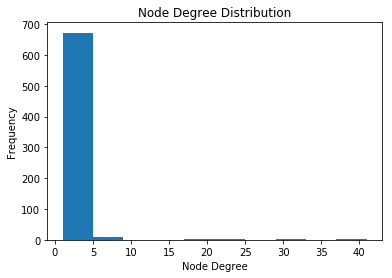

In [10]:
plt.hist(list(nx.degree(tp_graph).values()))
plt.title("Node Degree Distribution")
plt.xlabel("Node Degree")
plt.ylabel("Frequency")

As seen the node degree, it shows a high amount of positively skewed distributions, suggesting only a few users are mentioned by a lot of people.

## (c)

In [11]:
edge_list = [[n1, n2, tp_graph[n1][n2]['numberMentions']] for n1, n2 in tp_graph.edges()]

edge_df = pd.DataFrame(edge_list)
edge_df.columns = ["Node1", "Node2", "Weight"]

In [12]:
edge_df.sort_values('Weight', ascending=0).head(5)

Node1           Node2  Weight
25   thesnarkyone      justusleeg       6
244    diggaclean        daschund       3
228    diggaclean      diggaclean       3
522  destroytoday  captaincraigos       2
213    justusleeg            bc42       2

## (d)

In [13]:
def addRandomPositions(graph):
    posDict = dict((node,(random.gauss(0,10),random.gauss(0,10))) for node in graph.nodes())
    nx.set_node_attributes(graph, 'pos', posDict)

In [14]:
addRandomPositions(tp_graph)

In [15]:
# HTML(cl.to_html( cl.scales['9'] ))

In [16]:
orrd = cl.scales['9']['seq']['OrRd']
orrd20 = cl.interp(orrd, 20)
HTML(cl.to_html(orrd20))

In [17]:
def plotNetworkSizeColor(graph):
    scatters=[]

    for (node1, node2) in graph.edges():
        x0, y0 = graph.node[node1]['pos']
        x1, y1 = graph.node[node2]['pos']
        edgeWidth = graph[node1][node2]['numberMentions']
        edgeColor = int(19 * edgeWidth / 6.0)
        s = Scatter(
                x=[x0, x1],
                y=[y0, y1],
                hoverinfo='none',
                mode='lines', 
                line=Line(width=edgeWidth*2, color=orrd20[edgeColor]))
        scatters.append(s)

    for node in graph.nodes():
        xPos, yPos = graph.node[node]['pos']
        s = Scatter(
                x=[xPos], 
                y=[yPos], 
                hoverinfo='none',
                mode='marker', 
                marker=dict(
                    color='#888', 
                    size=8,
                    line=dict(width=1)))
        scatters.append(s)
    
    layout = Layout(showlegend=False)
    fig = Figure(data=scatters, layout=layout)
    iplot(fig, show_link=False)
    
def applyLayout(graph, layoutFunc):
    posDict = layoutFunc(graph) 
    nx.set_node_attributes(graph, "pos", posDict)

In [18]:
tp_graph_rand = tp_graph.copy()
applyLayout(tp_graph_rand, nx.random_layout)
plotNetworkSizeColor(tp_graph_rand)

# Q3: Content Analysis

## (a)

In [19]:
sw_set = set(stopwords.words('english'))
sw_set.update(['rt', 'http', 'com'])

In [20]:
def word_filter(word):
    return bool(not word.startswith("@") and
                not word.startswith("#") and
                not word.startswith("http") and
                len(word) > 2 and
                word not in sw_set)

In [22]:
counter = Counter()
pa = re.compile(r'[^a-zA-Z]+')
for tw in tp_df['tweet'].as_matrix():
    words = [word.strip(""" ,.:'\";""") for word in tw.lower().split()]
    words = [pa.sub('', word) for word in words if word_filter(word)]
    counter.update([word for word in words if word_filter(word)])

In [23]:
counter.most_common(20)

[('twitter', 117),
 ('download', 75),
 ('twitpocalypse', 68),
 ('fixes', 64),
 ('update', 63),
 ('tweetdeck', 58),
 ('please', 52),
 ('beta', 46),
 ('twitterrific', 46),
 ('release', 45),
 ('restart', 44),
 ('destroytwitter', 44),
 ('iphone', 40),
 ('version', 40),
 ('via', 38),
 ('app', 38),
 ('tweets', 37),
 ('patched', 36),
 ('may', 34),
 ('tweet', 32)]

The main theme is the users asking Twitter to patch or fix the bug due to integer limit overflow (#twipocalpyse).

## (b)

In [24]:
def user_commonwords(user):
    user_df = tp_df.loc[tp_df['user'] == user]
    counter = Counter()
    pa = re.compile(r'[^a-zA-Z]+')
    for tw in user_df['tweet'].as_matrix():
        words = [word.strip(""" ,.:'\";""") for word in tw.lower().split()]
        words = [pa.sub('', word) for word in words if word_filter(word)]
        counter.update([word for word in words if word_filter(word)])
    
    if len(counter)>2:
        commonwords = counter.most_common(3)
        text='Words: {}, {}, {}'.format(commonwords[0][0], commonwords[1][0], commonwords[2][0])
    else: 
        text = 'Most common less than 3'
    return text

In [25]:
def plotUserCommonWords(graph):
    scatters=[]

    for (node1, node2) in graph.edges():
        x0, y0 = graph.node[node1]['pos']
        x1, y1 = graph.node[node2]['pos']
        edgeWidth = graph[node1][node2]['numberMentions']
        s = Scatter(
                x=[x0, x1],
                y=[y0, y1],
                hoverinfo='none',
                mode='lines', 
                line=Line(width=1 ,color='#888'))
        scatters.append(s)

    for node in graph.nodes():
        xPos, yPos = graph.node[node]['pos']
        s = Scatter(
                x=[xPos], 
                y=[yPos],
                text=user_commonwords(node),
                hoverinfo='text',
                mode='marker', 
                marker=dict(
                    color="#888", 
                    size=10,         
                    line=dict(width=2)))
        scatters.append(s)

    layout = Layout(showlegend=False)
    fig = Figure(data=scatters, layout=layout)
    iplot(fig, show_link=False)

In [26]:
plotUserCommonWords(tp_graph)

# Q4: Centrality Analysis

## (a)

In [27]:
deg_centr = nx.degree_centrality(tp_graph)
clo_centr = nx.closeness_centrality(tp_graph)

## (b)

In [28]:
def plotCentr(graph, centr):
    maxCentr = max(centr.values())
    minCentr = min(centr.values())
    
    scatters=[]

    for (node1, node2) in graph.edges():
        x0, y0 = graph.node[node1]['pos']
        x1, y1 = graph.node[node2]['pos']
        edgeWidth = graph[node1][node2]['numberMentions']
        s = Scatter(
                x=[x0, x1],
                y=[y0, y1],
                hoverinfo='none',
                mode='lines', 
                line=Line(width=edgeWidth ,color='#888'))
        scatters.append(s)

    for node in graph.nodes():
        nodeCentr = centr[node]
        nodeColor = int(19*(nodeCentr-minCentr)/(maxCentr-minCentr))
        xPos, yPos = graph.node[node]['pos']
        s = Scatter(
                x=[xPos], 
                y=[yPos], 
                text="User: %s\nValue: %.3f" % (node, nodeCentr),
                hoverinfo='text',
                mode='marker', 
                marker=dict(
                    color=orrd20[nodeColor], 
                    size=nodeCentr*100,         
                    line=dict(width=2)))
        scatters.append(s)
    
    layout = Layout(showlegend=False)
    fig = Figure(data=scatters, layout=layout)
    iplot(fig, show_link=False)

In [29]:
plotCentr(tp_graph_rand, deg_centr)

Key player: @diggaclean 0.060, @destroytoday 0.047, @tweetdeck 0.042, @twitterrific 0.035, @techcrunch 0.029

In [30]:
plotCentr(tp_graph_rand, clo_centr)

Key player: @diggaclean 0.057, @destroytoday 0.047, @tweetdeck 0.037, @twitterrific 0.032, @p0_p0 0.030

## (c)

In [31]:
deg_centr_count = Counter(deg_centr)
clo_centr_count = Counter(clo_centr)

In [32]:
deg_centr_count.most_common(5)

[('diggaclean', 0.0597667638483965),
 ('destroytoday', 0.04664723032069971),
 ('tweetdeck', 0.04227405247813411),
 ('twitterrific', 0.03498542274052478),
 ('techcrunch', 0.029154518950437316)]

In [33]:
clo_centr_count.most_common(5)

[('diggaclean', 0.056851311953352766),
 ('destroytoday', 0.046992481203007516),
 ('tweetdeck', 0.03665139525197834),
 ('twitterrific', 0.031818181818181815),
 ('p0_p0', 0.030022951429812046)]

1. The results using degree and closeness centralities are quite similar. The key players are identified as @diggaclean, @destroytoday, @tweetdeck, @twitterrific, @techcrunch. The reason for the similarity is for degree centrality, the node connected with more edges gets higher score, and closeness measures the distances to all node from this node. If the node has more edges directly connected then, its distance to other nodes will be likely smaller, thus those two measures produce a similar result.
2. Degree centrality produces more meaningful interpretation, because it describes direct connections from one user to the others.

# Q5: Connectivity Patterns

## (a)

In [34]:
# 1) Number of maximal cliques in the graph
print("Number of maximal cliques:", len([clique for clique in nx.find_cliques(tp_graph)]))

Number of maximal cliques: 496


In [35]:
# 2) The graph's clique number (size of the largest clique in the graph)
print("The graph's clique number:", nx.graph_clique_number(tp_graph))

The graph's clique number: 4


In [36]:
# 3) Number of maximal cliques for each node
clique_df = pd.DataFrame(list(nx.number_of_cliques(tp_graph).items())) 
clique_df.columns=['user', 'maximal clique']
clique_df.sort_values('maximal clique', ascending=0)

user  maximal clique
192       diggaclean              38
648     destroytoday              32
340        tweetdeck              28
529     twitterrific              24
367       techcrunch              20
344    jason_pollock              17
366      kimsherrell               7
247               nk               6
512         mashable               6
492         tweets60               5
495  doubledown_insl               5
400      andybumatai               5
219          tweetie               5
679         nambucom               4
658           jprose               4
179       justusleeg               4
33        twitterapi               4
200    destroytoday)               3
30           rbosoni               3
523           kalaes               3
515     fossiloflife               3
40              rafe               3
541     odellbrewing               3
44        kikukoloko               3
606       kriscolvin               3
235      trilby_dare               3
169     queenofspain               3
119    trillianastra               3
126         suzydias               3
599       twitterfon               3
..               ...             ...
312    therealdjflux               1
313       eugeneiiim               1
314          kmcdade               1
316         shogun79               1
307       miclothing               1
317    radoxthegreen               1
318    noaffiliation               1
319      sliceonline               1
320         harpaa01               1
321    richardbarley               1
322         missylab               1
308            incom               1
306     jjmartin1987               1
290    darrengriffin               1
297            shaff               1
291            nocka               1
292      twitterific               1
293        samismail               1
294       linkdupont               1
295   wietseveenstra               1
296       sistema428               1
298          jnavarr               1
305   ptsdconference               1
299  terra_argentina               1
300           aplusk               1
72    monsieurnguyen               1
302       rafaelmagu               1
303      igorgsantos               1
304    tori_thompson               1
343     brainyvermin               1

[687 rows x 2 columns]

In [37]:
# 4) Size of the largest maximal clique containning each given node
node_clique_df = pd.DataFrame(list(nx.node_clique_number(tp_graph).items()))
node_clique_df.columns=['user', 'maximal clique']
node_clique_df.sort_values('maximal clique', ascending=0)

user  maximal clique
64           skanwar               4
425        digeratii               4
250          deabush               4
244     newfiejobber               4
220          tangute               3
608         arlenesg               3
498          9swords               3
164   blacknerdgirls               3
165           ahzing               3
543     babyscholars               3
154   msproductions)               3
192       diggaclean               3
116    theiphoneblog               3
79        pinkmotown               3
358          pyeager               3
457       zorrobiwan               3
340        tweetdeck               3
556          mdufort               3
355          tplayer               3
33        twitterapi               3
479            _arf_               3
683    chynagyrl1980               3
575          fbrunel               3
597        sarinhasi               3
504         vilaoooo               3
458       eternalcow               2
456        lizapotts               2
459       justmicael               2
0                                  2
460       angel1ruiz               2
..               ...             ...
254         dmooney9               2
255          hardy24               2
256            t_x_p               2
257          sadekhm               2
258     brighterhell               2
259          zasherb               2
260       ryaninmpls               2
222       drewbarbee               2
241        tollerton               2
239            maiat               2
231          suriehl               2
223         jew_news               2
224            sjr79               2
225         juliofsn               2
226       rfaulhaber               2
227    flynn_the_cat               2
228       mix0r:keep               2
229         chiieddy               2
230           achura               2
232          revisit               2
233        cdngal_ps               2
234         wiredpig               2
235      trilby_dare               2
236         shaheema               2
237  techruminations               2
238        bizarre57               2
686           mike9r               2
538       robroyalty               1
111     rjamestaylor               1
453            quoqu               1

[687 rows x 2 columns]

From the results above, we can see the graph overall has about a little less than 500 cliques. The user who has the more maximal clique are the key player identified from the previous centrality measure. Those key players are either some major user or official 3rd party media platforms. The rest of user with less maximal clique are aggregated into smaller groups.